In [4]:
import numpy as np
import spotpy
import pickle
import pandas as pd
from superflexpy.implementation.root_finders.pegasus import PegasusPython
from superflexpy.implementation.numerical_approximators.implicit_euler import ImplicitEulerPython
from superflexpy.implementation.elements.hymod import LinearReservoir
from superflexpy.implementation.elements.gr4j import ProductionStore
from superflexpy.implementation.elements.structure_elements import  Splitter, Junction
from superflexpy.framework.unit import Unit
from superflexpy.framework.element import ParameterizedElement

from datetime import datetime, timedelta
train_start = '01/10/2006'
train_end   = '30/09/2008'
basin = "01333000"

def load_data(basin,train_start,train_end):
    p = load_p(basin,train_start,train_end)
    pet = load_pet(basin,train_start,train_end)
    data = np.vstack((p,pet)).T
    return data
def load_p(basin,train_start,train_end):
    train_start_dt = datetime.strptime(train_start, '%d/%m/%Y')
    train_end = datetime.strptime(train_end, '%d/%m/%Y')
    len_seq = (train_end - train_start_dt).days
    f = open("data/CAMELS_US/basin_mean_forcing/daymet/02/"+basin+"_lump_cida_forcing_leap.txt")
    f.readline()
    f.readline()
    f.readline()
    f.readline()
    l = f.readline().split('\t')
    x = np.zeros(len_seq)
    train_start = train_start.split('/')
    train_start.reverse()
    train_start = ' '.join(train_start)
    while l[0] != train_start+' 12':
        l = f.readline().split('\t')
    for i in range(len_seq):
        x[i] = float(l[2])
        l = f.readline().split('\t')
    return x

def load_pet(basin,train_start,train_end):
    with open("data\pet.pkl", "rb") as fp:
        results = pickle.load(fp)
        results = results[basin]
        results.index = pd.to_datetime(results.index)
        train_start = datetime.strptime(train_start, '%d/%m/%Y')
        train_end = datetime.strptime(train_end, '%d/%m/%Y') - timedelta(days=1)
        results = results.loc[train_start:train_end]
        results = results['PET(mm/d)'].values
        results = np.maximum(0.0,results)
    return results

# 1 - Datasets

In [2]:
def get_area(basin):
    with open("data/CAMELS_US/basin_mean_forcing/daymet/02/"+basin+"_lump_cida_forcing_leap.txt", 'r') as fp:
        # load area from header
        fp.readline()
        fp.readline()
        area = int(fp.readline())
    return area

def load_qobs(basin,train_start,train_end):
    area = get_area(basin)
    train_start_dt = datetime.strptime(train_start, '%d/%m/%Y')
    train_end = datetime.strptime(train_end, '%d/%m/%Y')
    len_seq = (train_end - train_start_dt).days
    x = np.zeros(len_seq)
    train_start = train_start.split('/')
    train_start.reverse()
    train_start = ' '.join(train_start)
    f = open("data/CAMELS_US/usgs_streamflow/02/"+basin+"_streamflow_qc.txt")
    l = f.readline()[9:].split(" ")
    while ' '.join([l[i] for i in range(3)]) != train_start:
        l = f.readline()[9:].split(' ')
    for i in range(len_seq):
        x[i] = float(l[-2])
        l = f.readline()[9:].split(' ')
    x = 28316846.592 * x * 86400 / (area * 10**6)
    return x
    
P    = load_p(basin, train_start, train_end)
Ep   = load_pet(basin, train_start, train_end)
Qobs = load_qobs(basin, train_start, train_end)

# 2 - Superflex model creation

In [3]:
class ParameterizedSingleFluxSplitter(ParameterizedElement):
    _num_downstream = 2
    _num_upstream = 1
    
    def set_input(self, input):

        self.input = {'Q_in': input[0]}

    def get_output(self, solve=True):

        split_par = self._parameters[self._prefix_parameters + 'split-par']

        output1 = [self.input['Q_in'] * split_par]
        output2 = [self.input['Q_in'] * (1 - split_par)]
        
        return [output1, output2]   
    

def create_superflex_model():
    # Initialize numercal routines
    root_finder = PegasusPython()
    numeric_approximator = ImplicitEulerPython(root_finder=root_finder)

    # Initialize the elements
    lr_1 = LinearReservoir(
        parameters={'k': 0.5},
        states={'S0': 0.0},
        approximation=numeric_approximator,
        id='LR-1'
    )

    lr_2 = LinearReservoir(
        parameters={'k': 4.0},
        states={'S0': 0.0},
        approximation=numeric_approximator,
        id='LR-2'
    )

    tr = ProductionStore(
        parameters={'x1': 20.0, 'alpha': 2.0,
                    'beta': 2.0, 'ni': 0.0},
        states={'S0': 0.0},
        approximation=numeric_approximator,
        id='TR'
    )
    splitter = ParameterizedSingleFluxSplitter(
                        parameters={'split-par': 0.9},
                        id='spl'
    )

    junction = Junction(direction=[[0, 0]], # Third output
                        id='jun')

    model = Unit(layers=[[tr],
                        [splitter],
                        [lr_1, lr_2],
                        [junction]],
                id='model')
    return model

sf_model = create_superflex_model()

# 3 - Metric

In [4]:
def obj_fun_nsee(observations, simulation, expo = 0.5):
    metric = np.nansum(np.power(np.power(simulation, expo)  - np.power(observations,expo), 2)) / np.nansum(np.power(np.power(observations, expo)  - np.nanmean(np.power(observations, expo)), 2))
    return float(metric)

# 4 - Spotpy model

In [5]:
class spotpy_model(object):

    def __init__(self, model, inputs, dt, observations, parameters, parameter_names, output_index, 
                 warm_up = 365):

        self._model = model
        self._model.set_input(inputs)
        self._model.set_timestep(dt)

        self._parameters = parameters
        self._parameter_names = parameter_names
        self._observarions = observations
        self._output_index = output_index
        
        self._warm_up = int(warm_up)
        
    def parameters(self):
        return spotpy.parameter.generate(self._parameters)
    
    def simulation(self, parameters):

        named_parameters = {}
        for p_name, p in zip(self._parameter_names, parameters):
            named_parameters[p_name] = p

        self._model.set_parameters(named_parameters)
        self._model.reset_states()
        output = self._model.get_output()

        return output[self._output_index]
    
    def evaluation(self):
        return self._observarions
    
    # Here you can use a pre-defined objective function from spotpy, or you can write down your own:    
    def objectivefunction(self, simulation, evaluation):        
        evaluation_used = evaluation[self._warm_up + 1:]
        simulation_used = simulation[self._warm_up + 1:]
        obj_fun = obj_fun_nsee(observations = evaluation_used, simulation = simulation_used, expo = 0.5)
        
        return obj_fun

In [6]:
spotpy_sf = spotpy_model(
    model=sf_model,
    inputs=[Ep,P],
    dt=1.0,
    observations = Qobs,
    parameters=[
        spotpy.parameter.Uniform('model_TR_x1', 1.0, 50.0),
        spotpy.parameter.Uniform('model_LR-1_k', 0.01, 50.0),
        spotpy.parameter.Uniform('model_LR-2_k', 0.01, 50.0),
        spotpy.parameter.Uniform('model_spl_split-par', 0.0, 1.0)
    ],
    parameter_names=['model_TR_x1','model_LR-1_k','model_LR-2_k','model_spl_split-par'],
    output_index=0,
    warm_up=0
)

# 5 - Calibration

In [7]:
sampler = spotpy.algorithms.sceua(spotpy_sf, dbname='calibration', dbformat='csv')
sampler.sample(repetitions=1000)

Initializing the  Shuffled Complex Evolution (SCE-UA) algorithm  with  1000  repetitions
The objective function will be minimized
Starting burn-in sampling...
Initialize database...
['csv', 'hdf5', 'ram', 'sql', 'custom', 'noData']
* Database file 'calibration.csv' created.
49 of 1000, minimal objective function=0.784454, time remaining: 00:00:39
99 of 1000, minimal objective function=0.784454, time remaining: 00:00:37
148 of 1000, minimal objective function=0.784454, time remaining: 00:00:35
Burn-in sampling completed...
Starting Complex Evolution...
ComplexEvo loop #1 in progress...
213 of 1000, minimal objective function=0.784454, time remaining: 00:00:31
301 of 1000, minimal objective function=0.784454, time remaining: 00:00:24
392 of 1000, minimal objective function=0.784454, time remaining: 00:00:20
484 of 1000, minimal objective function=0.784454, time remaining: 00:00:16
569 of 1000, minimal objective function=0.784454, time remaining: 00:00:13
ComplexEvo loop #2 in progress...

# 6 - Running NH

In [11]:
from neuralhydrology.nh_run import start_run
from pathlib import Path
start_run(config_file=Path("examples/07-Superflex/example4.yml", gpu=-1))

2024-03-22 11:17:07,178: Logging to runs\run_2203_111707\output.log initialized.
2024-03-22 11:17:07,179: ### Folder structure created at runs\run_2203_111707
2024-03-22 11:17:07,180: ### Run configurations for run
2024-03-22 11:17:07,180: experiment_name: None
2024-03-22 11:17:07,181: run_dir: runs\run_2203_111707
2024-03-22 11:17:07,181: train_basin_file: examples\07-Superflex\6_basins_list.txt
2024-03-22 11:17:07,181: validation_basin_file: examples\07-Superflex\6_basins_list.txt
2024-03-22 11:17:07,181: test_basin_file: examples\07-Superflex\6_basins_list.txt
2024-03-22 11:17:07,181: train_start_date: 2006-10-01 00:00:00
2024-03-22 11:17:07,181: train_end_date: 2008-09-30 00:00:00
2024-03-22 11:17:07,181: validation_start_date: 2002-10-01 00:00:00
2024-03-22 11:17:07,181: validation_end_date: 2004-09-30 00:00:00
2024-03-22 11:17:07,181: test_start_date: 1998-10-01 00:00:00
2024-03-22 11:17:07,181: test_end_date: 2000-09-30 00:00:00
2024-03-22 11:17:07,190: per_basin_train_periods_f

2024-03-22 11:17:07,190: model: superflex
2024-03-22 11:17:07,190: model_description: examples/07-Superflex/archs/arch1.txt
2024-03-22 11:17:07,199: checkpoint_path: None
2024-03-22 11:17:07,200: head: regression
2024-03-22 11:17:07,200: output_activation: linear
2024-03-22 11:17:07,200: optimizer: Adam
2024-03-22 11:17:07,202: loss: NSE
2024-03-22 11:17:07,203: regularization: None
2024-03-22 11:17:07,203: learning_rate: {0: 0.01, 10: 0.01, 25: 0.001}
2024-03-22 11:17:07,204: batch_size: 32
2024-03-22 11:17:07,204: epochs: 25
2024-03-22 11:17:07,204: target_noise_std: 0.1
2024-03-22 11:17:07,204: clip_gradient_norm: 1
2024-03-22 11:17:07,207: predict_last_n: 1
2024-03-22 11:17:07,207: seq_length: 365
2024-03-22 11:17:07,208: num_workers: 1
2024-03-22 11:17:07,208: log_interval: 5
2024-03-22 11:17:07,208: log_tensorboard: True
2024-03-22 11:17:07,208: log_n_figures: -1
2024-03-22 11:17:07,208: save_weights_every: 5
2024-03-22 11:17:07,208: save_validation_results: True
2024-03-22 11:17

# 7 - Comparison

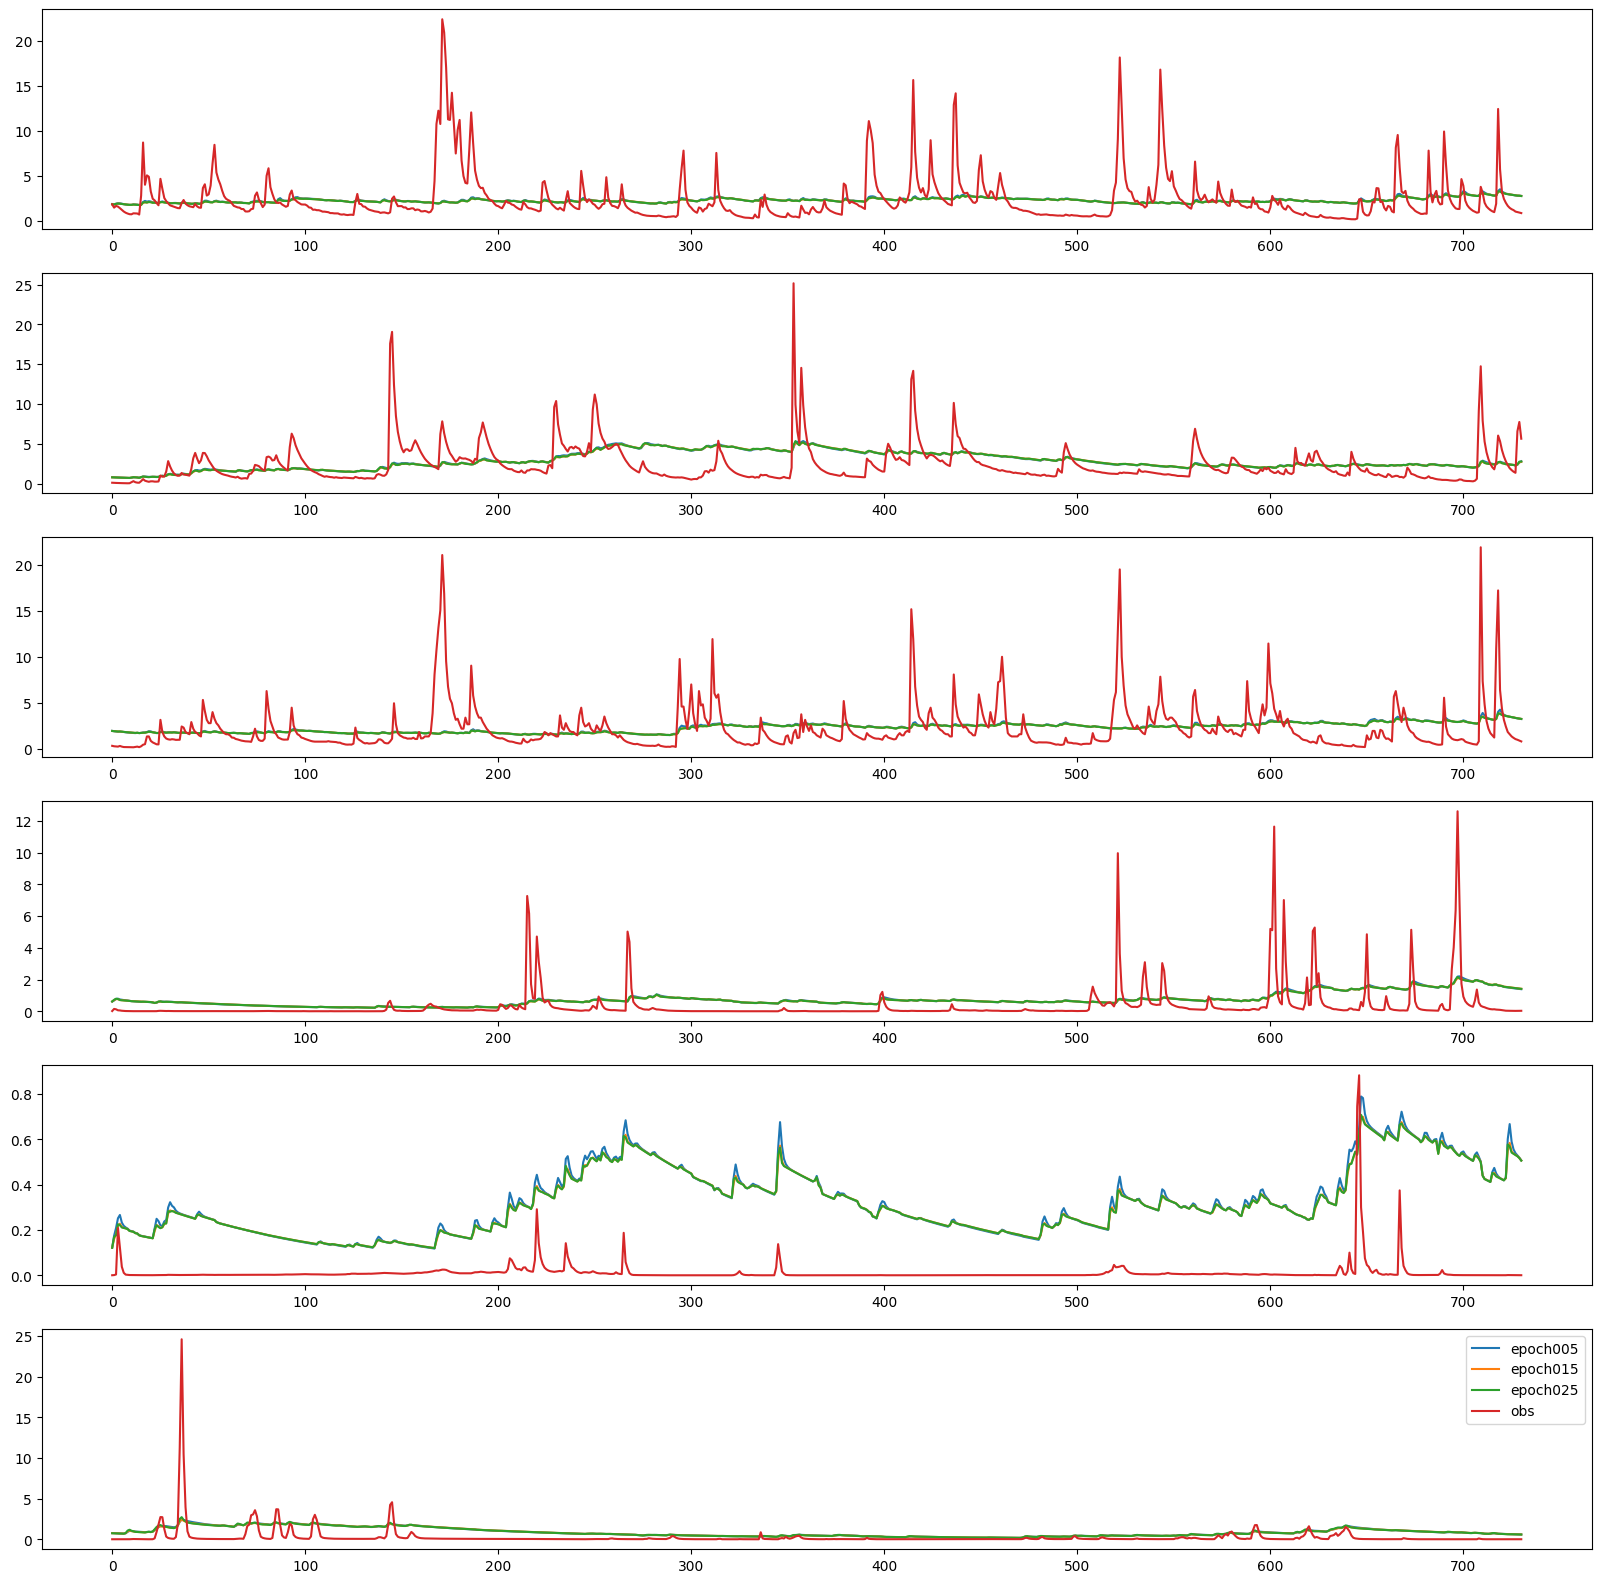

In [12]:
run_dir = "runs/run_2203_111707" #CHANGE IT
#basin = "01333000"
#root_finder = PegasusPython()
#numeric_approximator = ImplicitEulerPython(root_finder=root_finder)
#lr_1 = LinearReservoir(
#    parameters={'k': 0.147796},#0.0336838
#    states={'S0': 0.0},
#    approximation=numeric_approximator,
#    id='LR-1'
#)
#lr_2 = LinearReservoir(
#    parameters={'k': 7.81665},#18.2155
#    states={'S0': 0.0},
#    approximation=numeric_approximator,
#    id='LR-2'
#)
#tr = ProductionStore(
#    parameters={'x1': 673.3361, 'alpha': 2.0, #34.9774
#                'beta': 2.0, 'ni': 0.0},
#    states={'S0': 0.0},
#    approximation=numeric_approximator,
#    id='TR'
#)
#splitter = Splitter(weight=[[0.758911], [1.0-0.758911]], #0.635073
#                direction=[[0], [0]],
#                id='spl')
#
#junction = Junction(direction=[[0, 0]], # Third output
#                    id='jun')
#
#model_sf = Unit(layers=[[tr],
#                    [splitter],
#                    [lr_1, lr_2],
#                    [junction]],
#            id='model')
#
#P = load_p(basin, '01/10/2002','30/09/2004')
#Ep = load_pet(basin, '01/10/2002','30/09/2004')
#
#model_sf.reset_states()
#model_sf.set_input([Ep,P])
#model_sf.set_timestep(1.0)
#output_sf = model_sf.get_output()[0]
#
#
#
#import pickle
#import matplotlib.pyplot as plt
#from math import sqrt
#
#def mean(l):
#    return sum(l)/len(l)
#
#def stdev(l):
#    m = mean(l)
#    return sqrt(sum([(i-m)**2 for i in l])/len(l))
#
#import seaborn as sns
basins = ["01510000",
          "02027500",
          "03026500",
          "05487980",
          "06853800",
          "08175000"]
fig, ax = plt.subplots(len(basins), figsize=(20, 20))
for ib, basin in enumerate(basins):
    for nb_epochs in range(5,26,10):
    #nb_epochs = 25
        nb_epochs = str(nb_epochs)
        nb_epochs = (3-len(nb_epochs))*'0'+nb_epochs

        with open(run_dir + "/validation/model_epoch"+nb_epochs+"/validation_results.p", "rb") as fp:
            results = pickle.load(fp)
            qsim = results[basin]['1D']['xr']['QObs(mm/d)_sim'].squeeze().values
            qobs = results[basin]['1D']['xr']['QObs(mm/d)_obs']
            #sns.lineplot(data=pd.DataFrame({'nh epoch '+str(nb_epochs):qsim.squeeze()}))
            ax[ib].plot(qsim,label='epoch'+nb_epochs)
            #print(qobs[:10])
            #kge_nh = metrics.kge(qobs.isel(time_step=-1)[1:],qsim.isel(time_step=-1)[1:])
    ax[ib].plot(qobs.squeeze().values,label='obs')
plt.legend()
plt.show()
#sns.lineplot(data=pd.DataFrame({'obs':qobs.squeeze()}))

#sns.set_theme(style="darkgrid")
#warmup = 365
#
#dates = qobs.isel(time_step=-1)[1:].coords['date'].data
#output_sf_xarray = DataArray(output_sf, coords={'date': dates, 'time_step': -1},
#                                dims=['date'])
#kge_sf = metrics.kge(qobs.isel(time_step=-1)[1:],output_sf_xarray)
#
#print("KGE NH:",kge_nh, "\nKGE SF:",kge_sf)
# Plot the responses for different events and regions
#sns.lineplot(data=pd.DataFrame({'observed':qobs, "nh": qobs2.squeeze().values[:-1]}))
